In [1]:
import scanpy as sc
import gseapy as gp
import matplotlib.pyplot as plt
import gseapy as gp
import anndata as ad
import decoupler
from pathlib import Path

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
split = 3

In [3]:
adata_pred_ood = sc.read(f"/lustre/groups/ml01/workspace/ot_perturbation/models/otfm/combosciplex/adata_ood_with_predictions_{split}.h5ad")
#adata_pred_test = sc.read(f"/lustre/groups/ml01/workspace/ot_perturbation/models/otfm/combosciplex/adata_test_with_predictions_{split}.h5ad")

In [4]:
adata_pred_ood.X = adata_pred_ood.layers["X_recon_pred"]
#adata_pred_test.X = adata_pred_test.layers["X_recon_pred"]

In [5]:
adata_train_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_train_{split}.h5ad"
adata_test_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_test_{split}.h5ad"
adata_ood_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_ood_{split}.h5ad"

In [6]:
adata_train = sc.read(adata_train_path)
adata_test = sc.read(adata_test_path)
adata_ood = sc.read(adata_ood_path)

In [7]:
adata_pred_ood = adata_pred_ood[adata_pred_ood.obs["condition"]!="control"]

In [15]:
adata_pred_ood.var_names = adata_ood.var_names
#adata_pred_test.var_names = adata_test.var_names

In [49]:
adata_pred_ood.obs["condition"] = adata_pred_ood.obs.apply(lambda x: x["condition"] + "_pred", axis=1)

In [50]:
adata_full = ad.concat((adata_train, adata_ood, adata_pred_ood))

In [71]:
sc.pp.normalize_total(adata_full)

In [51]:
adata_full.obs["condition"].value_counts()

condition
Dacinostat+PCI-34051            3198
SRT3025+Cediranib               2916
Givinostat+Cediranib            2683
control+SRT2104                 2656
Givinostat+Curcumin             2636
Givinostat+Sorafenib            2634
Givinostat+Carmofur             2592
Givinostat+Crizotinib           2562
Givinostat+Dasatinib            2321
Givinostat+SRT2104              2253
Panobinostat+Curcumin           2244
control+Dasatinib               2243
Givinostat+SRT1720              2160
Cediranib+PCI-34051             2061
Panobinostat+Sorafenib          2013
Panobinostat+SRT2104            1871
control+Dacinostat              1869
Panobinostat+Dasatinib          1855
Dacinostat+Danusertib           1839
Panobinostat+SRT1720            1826
Panobinostat+SRT3025            1789
Panobinostat+PCI-34051          1714
Panobinostat+Crizotinib         1641
control+Givinostat              1582
control+Panobinostat            1478
control                         1451
Givinostat+Tanespimycin     

In [18]:
if not Path("c2.cp.reactome.v7.5.1.symbols.gmt").is_file():
    !wget -O 'c2.cp.reactome.v7.5.1.symbols.gmt' https://figshare.com/ndownloader/files/35233771

In [19]:
import pandas as pd
def gmt_to_decoupler(pth: Path) -> pd.DataFrame:
    """
    Parse a gmt file to a decoupler pathway dataframe.
    """
    from itertools import chain, repeat

    pathways = {}

    with Path(pth).open("r") as f:
        for line in f:
            name, _, *genes = line.strip().split("\t")
            pathways[name] = genes

    return pd.DataFrame.from_records(
        chain.from_iterable(zip(repeat(k), v) for k, v in pathways.items()),
        columns=["geneset", "genesymbol"],
    )



In [20]:
reactome = gmt_to_decoupler("c2.cp.reactome.v7.5.1.symbols.gmt")

In [21]:
# Retrieving via python
msigdb = decoupler.get_resource("MSigDB")

# Get reactome pathways
reactome = msigdb.query("collection == 'reactome_pathways'")
# Filter duplicates
reactome = reactome[~reactome.duplicated(("geneset", "genesymbol"))]


In [72]:
sc.tl.rank_genes_groups(adata_full, "condition", method="t-test", key_added="t-test", reference="control")

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:4

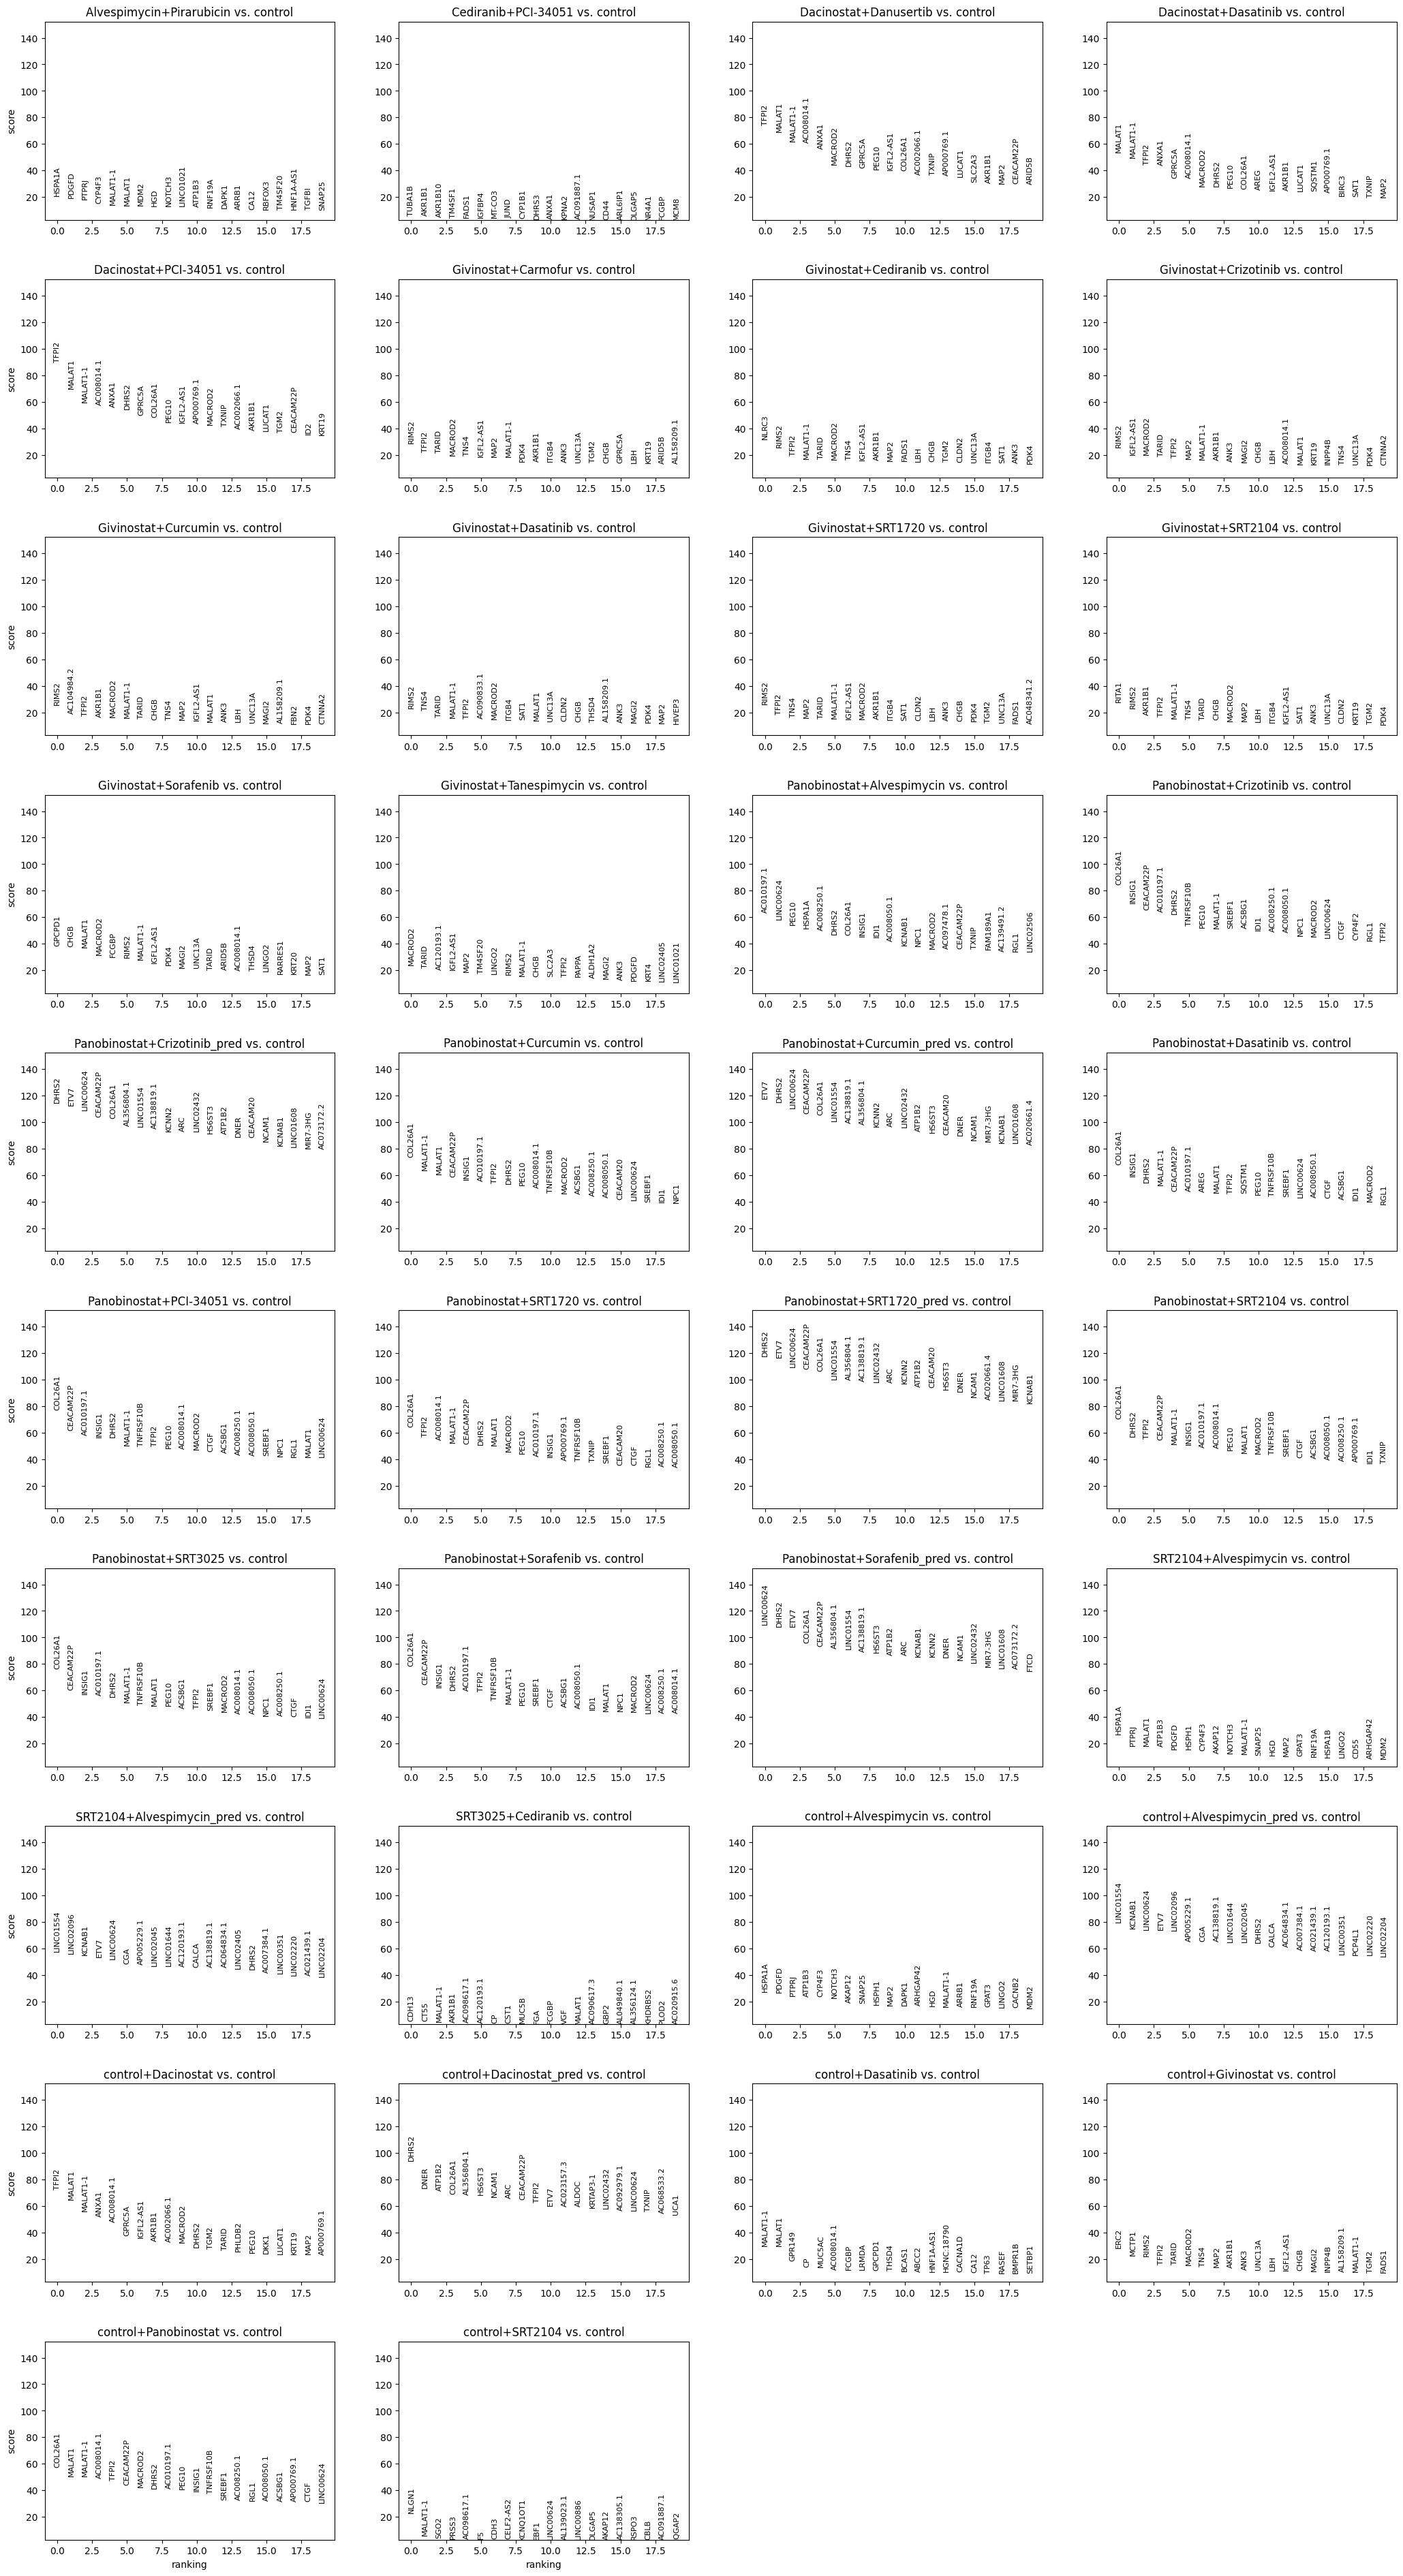

In [73]:
sc.pl.rank_genes_groups(adata_full, key="t-test")

In [74]:
import numpy as np
dict_t_stats = {}

for condition in adata_full.obs["condition"].cat.categories:
    if condition=="control":
        continue
    t_stats = (
        # Get dataframe of DE results for condition vs. rest
        sc.get.rank_genes_groups_df(adata_full, group=condition,  key="t-test")
        .set_index("names")
        # Sort by absolute score
        .sort_values("scores", key=np.abs, ascending=False)
        # Format for decoupler
        [["scores"]]
    )
    dict_t_stats[condition] = t_stats

In [55]:
# Filtering genesets to match behaviour of fgsea
geneset_size = reactome.groupby("geneset").size()
gsea_genesets = geneset_size.index[(geneset_size > 15) & (geneset_size < 500)]

/tmp/ipykernel_2486632/1613302725.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  geneset_size = reactome.groupby("geneset").size()


In [75]:
dict_gsea_results = {}

for condition, t_stats in dict_t_stats.items():
    scores, norm, pvals = decoupler.run_gsea(
        t_stats.T,
        reactome[reactome["geneset"].isin(gsea_genesets)],
        source="geneset",
        target="genesymbol",
    )
    gsea_results = (
        pd.concat({"score": scores.T, "norm": norm.T, "pval": pvals.T}, axis=1)
        .droplevel(level=1, axis=1)
        .sort_values("pval")
    )
    dict_gsea_results[condition] = gsea_results



In [57]:
dict_gsea_results.keys()

dict_keys(['Alvespimycin+Pirarubicin', 'Cediranib+PCI-34051', 'Dacinostat+Danusertib', 'Dacinostat+Dasatinib', 'Dacinostat+PCI-34051', 'Givinostat+Carmofur', 'Givinostat+Cediranib', 'Givinostat+Crizotinib', 'Givinostat+Curcumin', 'Givinostat+Dasatinib', 'Givinostat+SRT1720', 'Givinostat+SRT2104', 'Givinostat+Sorafenib', 'Givinostat+Tanespimycin', 'Panobinostat+Alvespimycin', 'Panobinostat+Crizotinib', 'Panobinostat+Crizotinib_pred', 'Panobinostat+Curcumin', 'Panobinostat+Curcumin_pred', 'Panobinostat+Dasatinib', 'Panobinostat+PCI-34051', 'Panobinostat+SRT1720', 'Panobinostat+SRT1720_pred', 'Panobinostat+SRT2104', 'Panobinostat+SRT3025', 'Panobinostat+Sorafenib', 'Panobinostat+Sorafenib_pred', 'SRT2104+Alvespimycin', 'SRT2104+Alvespimycin_pred', 'SRT3025+Cediranib', 'control+Alvespimycin', 'control+Alvespimycin_pred', 'control+Dacinostat', 'control+Dacinostat_pred', 'control+Dasatinib', 'control+Givinostat', 'control+Panobinostat', 'control+SRT2104'])

In [58]:
dict_gsea_results['Alvespimycin+Pirarubicin']

,score,norm,pval
source,,,
REACTOME_SEPARATION_OF_SISTER_CHROMATIDS,-0.912325,-1.989994,0.000000
REACTOME_MITOTIC_SPINDLE_CHECKPOINT,-0.911168,-1.911232,0.000000
REACTOME_DISEASES_OF_DNA_REPAIR,-0.947468,-1.765994,0.000000
REACTOME_CELL_CYCLE_CHECKPOINTS,-0.877327,-2.172321,0.000000
REACTOME_MITOTIC_PROMETAPHASE,-0.914650,-2.092394,0.000000
...,...,...,...
REACTOME_AMINE_LIGAND_BINDING_RECEPTORS,-0.313093,-0.576856,0.919499
REACTOME_CHEMOKINE_RECEPTORS_BIND_CHEMOKINES,-0.287611,-0.505407,0.975089
REACTOME_TRANSCRIPTIONAL_REGULATION_OF_WHITE_ADIPOCYTE_DIFFERENTIATION,-0.246943,-0.433137,0.987972


In [66]:
[el for el in dict_gsea_results['Alvespimycin+Pirarubicin'].index if "TP53" in el]

['REACTOME_TRANSCRIPTIONAL_REGULATION_BY_TP53',
 'REACTOME_REGULATION_OF_TP53_ACTIVITY_THROUGH_PHOSPHORYLATION',
 'REACTOME_REGULATION_OF_TP53_ACTIVITY']

In [64]:
adata_full.var_names

Index(['C1orf112', 'CFTR', 'KLHL13', 'TFPI', 'SLC7A2', 'CD38', 'PDK4', 'MEOX1',
       'ZFX', 'ASB4',
       ...
       'AC139493.2', 'AC007529.2', 'AL355860.1', 'AC020915.6', 'MIR3658',
       'AC006460.2', 'AL589669.1', 'AC020912.1', 'AL805961.1', 'AL031731.1'],
      dtype='object', name='gene_short_name', length=2000)

In [59]:
'REACTOME_REGULATION_OF_TP53_ACTIVITY' # 'Alvespimycin+Pirarubicin'
'REACTOME_REGULATION_OF_TP53_ACTIVITY' # maybe even more interesting, as it's for 'Givinostat+Tanespimycin' and 'Alvespimycin+Pirarubicin'
'REACTOME_TRANSCRIPTIONAL_REGULATION_BY_TP53' # affects many conditions, a bit random

'REACTOME_TRANSCRIPTIONAL_REGULATION_BY_TP53'

In [79]:
1

1

In [80]:
dict_gsea_results['Alvespimycin+Pirarubicin']

,score,norm,pval
source,,,
REACTOME_RHO_GTPASE_EFFECTORS,-0.875582,-2.161773,0.000000
REACTOME_G2_M_CHECKPOINTS,-0.938334,-2.070434,0.000000
REACTOME_REPRODUCTION,-0.932844,-1.637867,0.000000
REACTOME_CELL_CYCLE_CHECKPOINTS,-0.880816,-2.208474,0.000000
REACTOME_MITOTIC_PROMETAPHASE,-0.917834,-2.099821,0.000000
...,...,...,...
REACTOME_AMINE_LIGAND_BINDING_RECEPTORS,-0.293485,-0.536247,0.938628
REACTOME_CHEMOKINE_RECEPTORS_BIND_CHEMOKINES,-0.276233,-0.479457,0.972325
REACTOME_TRANSCRIPTIONAL_REGULATION_OF_WHITE_ADIPOCYTE_DIFFERENTIATION,0.246314,0.466471,0.972973


In [81]:
res = {}
res_score = {}
res_norm = {}
for cond, df in dict_gsea_results.items():
    res[cond] = df.loc['REACTOME_REGULATION_OF_TP53_ACTIVITY_THROUGH_PHOSPHORYLATION']["pval"]
    res_score[cond] = df.loc['REACTOME_REGULATION_OF_TP53_ACTIVITY_THROUGH_PHOSPHORYLATION']["score"]
    res_norm[cond] = df.loc['REACTOME_REGULATION_OF_TP53_ACTIVITY_THROUGH_PHOSPHORYLATION']["norm"]

In [82]:
res_score


{'Alvespimycin+Pirarubicin': -0.74895537,
 'Cediranib+PCI-34051': -0.26645315,
 'Dacinostat+Danusertib': -0.91976327,
 'Dacinostat+Dasatinib': -0.9147971,
 'Dacinostat+PCI-34051': -0.9065108,
 'Givinostat+Carmofur': -0.9465619,
 'Givinostat+Cediranib': -0.9341035,
 'Givinostat+Crizotinib': -0.88820547,
 'Givinostat+Curcumin': -0.8651103,
 'Givinostat+Dasatinib': -0.90685284,
 'Givinostat+SRT1720': -0.9262028,
 'Givinostat+SRT2104': -0.9219086,
 'Givinostat+Sorafenib': -0.9402423,
 'Givinostat+Tanespimycin': -0.90159047,
 'Panobinostat+Alvespimycin': -0.82205003,
 'Panobinostat+Crizotinib': -0.82297665,
 'Panobinostat+Crizotinib_pred': -0.9051621,
 'Panobinostat+Curcumin': -0.84238666,
 'Panobinostat+Curcumin_pred': -0.9027545,
 'Panobinostat+Dasatinib': -0.82048863,
 'Panobinostat+PCI-34051': -0.829054,
 'Panobinostat+SRT1720': -0.8631005,
 'Panobinostat+SRT1720_pred': -0.90823257,
 'Panobinostat+SRT2104': -0.8500733,
 'Panobinostat+SRT3025': -0.83221895,
 'Panobinostat+Sorafenib': -0.

In [83]:
gsea_results = dict_gsea_results['Alvespimycin+Pirarubicin']

In [87]:
import seaborn.objects as so

(
    so.Plot(
        data=(
            gsea_results.head(5).assign(
                **{"-log10(pval)": lambda x: (x["score"])}
            )
        ),
        x="-log10(pval)",
        y="source",
    ).add(so.Bar())
)

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/seaborn/_core/plot.py:1043: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.savefig(buffer, dpi=dpi, format="png", bbox_inches="tight")


KeyboardInterrupt: 

In [89]:
import seaborn as sns
dict_gsea_results['Alvespimycin+Pirarubicin']["source"] = dict_gsea_results['Alvespimycin+Pirarubicin'].index
sns.barplot(data=dict_gsea_results['Alvespimycin+Pirarubicin'].head(10), x="source", y="score")

<Axes: xlabel='source', ylabel='score'>

Error in callback <function _draw_all_if_interactive at 0x7f17f2342200> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f1766e39120> (for post_execute):


KeyboardInterrupt: 

In [91]:
df_tmp = dict_gsea_results['Alvespimycin+Pirarubicin'].head(10)

<Axes: xlabel='source', ylabel='pval'>

Error in callback <function _draw_all_if_interactive at 0x7f17f2342200> (for post_execute):


KeyboardInterrupt: 

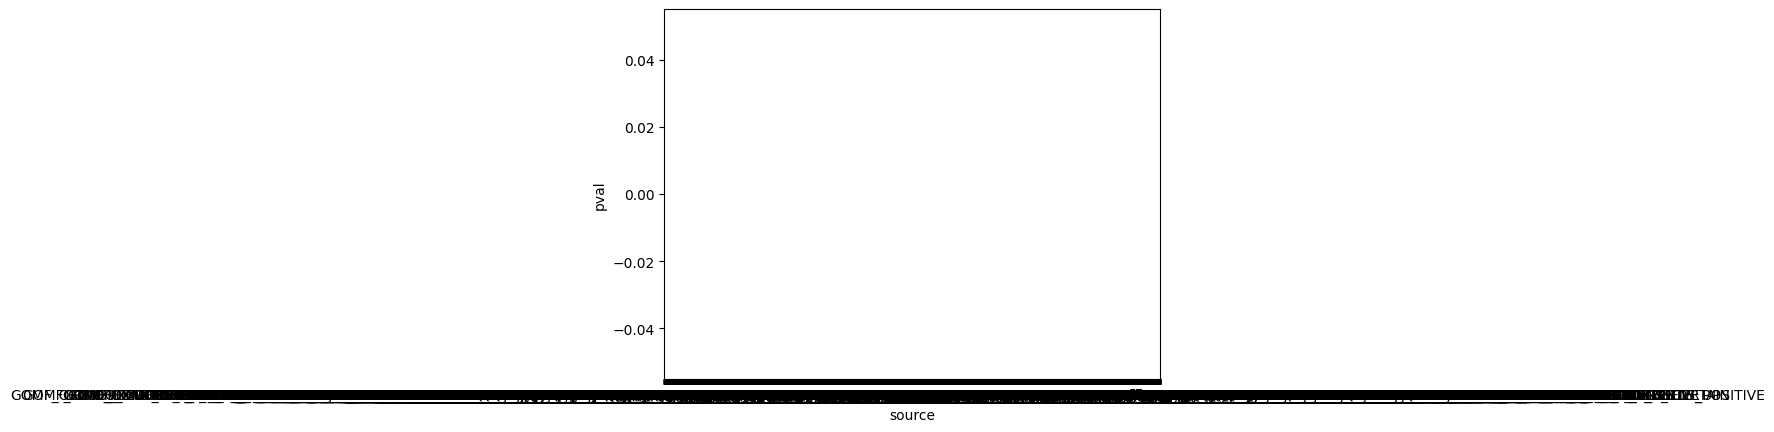

In [92]:
sns.barplot(df_tmp, x="source", y="pval")

In [41]:
adata_pred_ood.obs["condition"].value_counts()

condition
Panobinostat+Crizotinib    500
Panobinostat+Curcumin      500
Panobinostat+SRT1720       500
Panobinostat+Sorafenib     500
SRT2104+Alvespimycin       500
control+Alvespimycin       500
control+Dacinostat         500
Name: count, dtype: int64

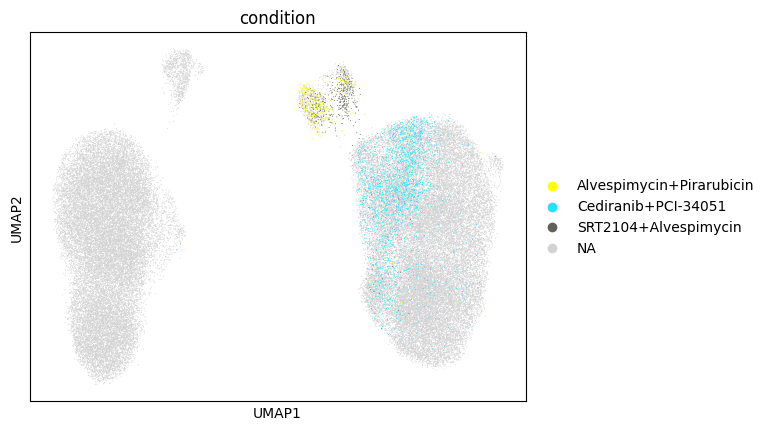

In [43]:
sc.pl.umap(adata_full, color="condition", groups=['Cediranib+PCI-34051', 'SRT2104+Alvespimycin', 'Alvespimycin+Pirarubicin'])

In [48]:
adata_ood.obs["condition"].value_counts()

condition
SRT3025+Cediranib         3016
Givinostat+Dasatinib      2421
control+Dasatinib         2343
Givinostat+SRT1720        2260
Panobinostat+SRT2104      1971
Panobinostat+Dasatinib    1955
Panobinostat+PCI-34051    1814
Name: count, dtype: int64

In [55]:
split = 3
ood_tmp_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_ood_{split}.h5ad"
adata_ood_tmp = sc.read_h5ad(ood_tmp_path)

In [56]:
adata_ood_tmp.obs["condition"].value_counts()

condition
Panobinostat+Curcumin      2244
Panobinostat+Sorafenib     2013
control+Dacinostat         1869
Panobinostat+SRT1720       1826
Panobinostat+Crizotinib    1641
control+Alvespimycin        758
SRT2104+Alvespimycin        520
control                     500
Name: count, dtype: int64

In [44]:
res = {}
for cond, df in dict_gsea_results.items():
    res[cond] = df.loc['REACTOME_TRANSCRIPTIONAL_REGULATION_BY_TP53']["pval"]

In [45]:
res


{'Alvespimycin+Pirarubicin': 0.0099502485,
 'Cediranib+PCI-34051': 0.013767209,
 'Dacinostat+Danusertib': 0.009049774,
 'Dacinostat+Dasatinib': 0.009124087,
 'Dacinostat+PCI-34051': 0.010958904,
 'Givinostat+Carmofur': 0.004716981,
 'Givinostat+Cediranib': 0.032786883,
 'Givinostat+Crizotinib': 0.0,
 'Givinostat+Curcumin': 0.0,
 'Givinostat+SRT2104': 0.030612245,
 'Givinostat+Sorafenib': 0.0025575447,
 'Givinostat+Tanespimycin': 0.013245033,
 'Panobinostat+Alvespimycin': 0.04694836,
 'Panobinostat+Crizotinib': 0.075987846,
 'Panobinostat+Curcumin': 0.015189873,
 'Panobinostat+SRT1720': 0.022038568,
 'Panobinostat+SRT3025': 0.05929919,
 'Panobinostat+Sorafenib': 0.03583062,
 'SRT2104+Alvespimycin': 0.17307693}

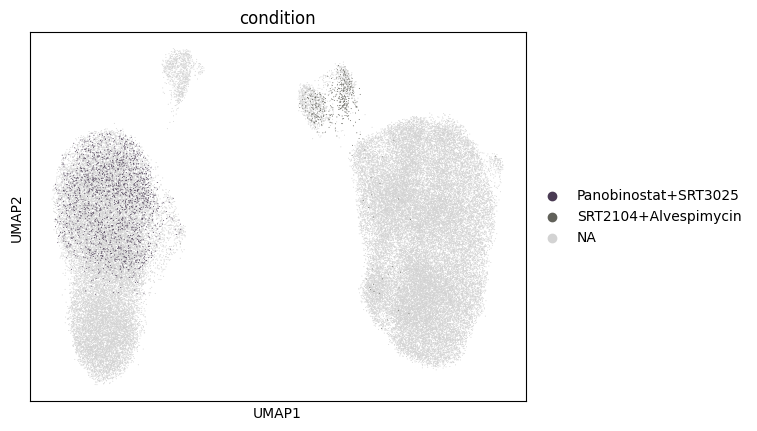

In [47]:
sc.pl.umap(adata_full, color="condition", groups=['SRT2104+Alvespimycin', 'Panobinostat+SRT3025'])

In [157]:
[el for el in adata_train.var_names if "TP" in el] 

['ATP1B3',
 'TP63',
 'TPX2',
 'ATP1B2',
 'PTPRJ',
 'PTPRD',
 'PITPNC1',
 'TPPP3',
 'CTPS1',
 'MCTP1',
 'TPRX1',
 'ATP13A5',
 'GRTP1-AS1',
 'ATP6V1G2-DDX39B']

In [151]:
adata_ood.obs["condition"].value_counts()

condition
Dacinostat+PCI-34051         3298
Givinostat+Cediranib         2783
Givinostat+Curcumin          2736
Panobinostat+SRT3025         1889
control+Panobinostat         1578
Dacinostat+Dasatinib         1231
Panobinostat+Alvespimycin     996
Name: count, dtype: int64

In [101]:
import seaborn.objects as so

In [111]:
[el for el in gsea_results.index.values if "EGFR" in el]

[]

In [102]:
(
    so.Plot(
        data=(
            gsea_results.head(20).assign(
                **{"-log10(pval)": lambda x: -np.log10(x["pval"])}
            )
        ),
        x="-log10(pval)",
        y="source",
    ).add(so.Bar())
)

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/seaborn/_core/plot.py:1043: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.savefig(buffer, dpi=dpi, format="png", bbox_inches="tight")


KeyboardInterrupt: 